# Проект: Анализ данных вакансий HH.ru

## Описание проекта
### Цель проекта
Выявить различия в вакансиях для Аналитиков данных и Системных аналитиков. Определить типичные для каждой вакансии условия работы, узнать как они меняются с ростом компетенций.

### Источник данных
Данные предварительно выгружены с использованием API сайта HH.ru в таблицы `excel`, отдельно для каждой группы вакансий. В данных содержатся вакансии, опубликованные с мая по ноябрь 2024 года.

### Описание данных:
 - `id` - Уникальный идентификатор вакансии.
 - `name` - Название вакансии.
 - `published_at` - Дата публикации.
 - `alternate_url` - Ссылка на вакансию.
 - `type` - Статус вакансии на момент получения данных от api и передачи их в базу.
 - `employer` - Работодатель.
 - `department` - Работодатель, отдел.
 - `area` - Регион места работы.
 - `experience` - Требуемый опыт работы.
 - `key_skills` - Ключевые навыки, в том числе найденные при анализе полного текста вакансии. Поле генерируется после получения информации от api.
 - `schedule` - График работы.
 - `employment` - Тип занятости.
 - `description` - Описание вакансии.
 - `description_lemmatized` - Лемматизированное описание вакансии.
 - `salary_from` - Нижняя граница предлагаемой заработной платы.
 - `salary_to` - Верхняя граница предлагаемой заработной платы.
 - `salary_bin` - Категория зарплаты.

Установка не стандартных библиотек

In [ ]:
$ pip install pypalettes

Подключение библиотек

In [101]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pypalettes

# Установим максимальную ширину вывода столбцов
pd.set_option('display.max_colwidth', 50)

# Отключим предупреждения
warnings.filterwarnings('ignore')

# Выбор цветового набора для визуализаций
cmap = pypalettes.load_cmap('ArcticGates')
cmap_cont = pypalettes.load_cmap('ArcticGates', cmap_type='continuous')

## Получение данных

Данные о вакансиях для Аналитика данных и Системного аналитика находятся в отдельных файлах. Объединим их, обозначив каждый сет признаком в столбце `jobs`.

In [102]:
# Откроем файлы с данными
df_da = pd.read_excel(r'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/Kck9O3jZ8BvHVw')
df_sa = pd.read_excel(r'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/nyuKsJja8GuaiQ')

# Добавим столбец с названием группы вакансий
df_da['job'] = 'Дата аналитик'
df_sa['job'] = 'Системный аналитик'

# Объединим датасеты
df = pd.concat([df_da, df_sa], ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4714 entries, 0 to 4713
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      4714 non-null   int64         
 1   name                    4714 non-null   object        
 2   published_at            4714 non-null   datetime64[ns]
 3   alternate_url           4714 non-null   object        
 4   type                    4714 non-null   object        
 5   employer                4714 non-null   object        
 6   department              1128 non-null   object        
 7   area                    4714 non-null   object        
 8   experience              4714 non-null   object        
 9   key_skills              4714 non-null   object        
 10  schedule                4714 non-null   object        
 11  employment              4714 non-null   object        
 12  description             4714 non-null   object  

### Пропуски

В получившемся датасете имеется 4714 вакансий. В некоторых столбцах есть пропуски:
- `department`: Подразделение компании, не интересно в рамках исследования;
- `description_lemmatized`: Текст из поля `description`, приведенный к основной форме. При необходимости сделаем обработку;
- `salary_from`, `salary_to`: Один из ключевых параметров, но сайт позволяет не указывать вилку при публикации вакансии. Если данные отсутствуют, отметим вакансии в поле `salary bin`.

### Типы данных

Сформируем таблицу, содержащую одновременно типы данных и срез самих данных для проверки.

In [103]:
pd.concat([df.dtypes, df.head(1).T], axis=1)

,0,0
id,int64,100039284
name,object,Junior аналитик данных (исследователь)
published_at,datetime64[ns],2024-05-24 09:37:04
alternate_url,object,https://hh.ru/vacancy/100039284
type,object,Открытая
employer,object,DNS Головной офис
department,object,NaN
area,object,Владивосток
experience,object,Junior (no experince)
key_skills,object,"['Power BI', 'СУБД', 'Python', 'SQL']"


Типы данных в столбцах определились успешно, конвертация не требуется. В поле key_skills находится список в виде строки. В блоке с анализом навыков выполним преобразование.

## Предобработка данных.

### Добавление столбцов


In [104]:
# Вынесем дату публикации вакансии в отдельный столбец
df['date'] = pd.to_datetime(df.published_at.dt.date)

df['date'].head()

0   2024-05-24
1   2024-05-24
2   2024-05-24
3   2024-05-24
4   2024-05-24
Name: date, dtype: datetime64[ns]

In [105]:
### Извлечем грейд из столбца experience
df['grade'] = df.experience.apply(lambda x: x.split()[0])

df.grade.unique()

array(['Junior', 'Junior+', 'Middle', 'Senior'], dtype=object)

### Проверка дубликатов

Поищем неявные дубликаты в столбцах, содержащих названия работодателей

In [106]:
df[df.employer.str.contains('Яндекс')].employer.unique()

array(['Яндекс', 'Яндекс Практикум'], dtype=object)

In [107]:
df[df.employer.str.contains('СБЕР')].employer.unique()

array(['СБЕР', 'СБЕР (ООО еАптека)', 'СБЕРКОРУС'], dtype=object)

In [108]:
df[df.employer.str.contains('DNS')].employer.unique()

array(['DNS Головной офис',
       'Сеть магазинов цифровой и бытовой техники DNS', 'DNS Технологии'],
      dtype=object)

Данные содержат различные подразделения одной компании в столбце `employer`. Не смотря на это, у них различаются виды деятельности, как например СБЕР это банковский сектор, СБЕР-еаптека - оборот лекарственных средств. Будем рассматривать их как отдельных работодателей.

## Исследовательский анализ данных


### Доли вакансий по грейдам

Определим доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Системный аналитик.

In [109]:
# Посчитаем количество вакансий в каждой группе
grade_counts = df[['job', 'grade']].value_counts().unstack()

# Разделим каждое значение на сумму вакансий в его группе
grade_share = grade_counts.div(grade_counts.sum(axis=1), axis=0).stack().reset_index()

# Переименуем столбцы
grade_share.columns = ['job', 'grade', 'share']

# Выведем результат с форматированием столбца в виде %
grade_share.style.format("{:.2%}", subset='share')

,job,grade,share
0,Дата аналитик,Junior,7.47%
1,Дата аналитик,Junior+,59.56%
2,Дата аналитик,Middle,31.80%
3,Дата аналитик,Senior,1.18%
4,Системный аналитик,Junior,4.49%
5,Системный аналитик,Junior+,44.49%
6,Системный аналитик,Middle,48.72%
7,Системный аналитик,Senior,2.30%


Построим диаграмму по этой таблице

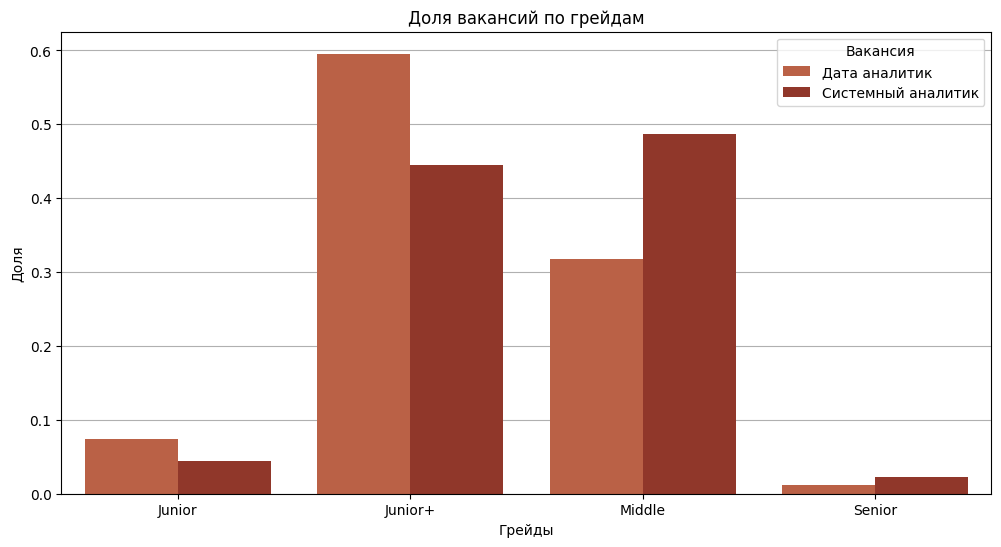

In [110]:
# Размер изображения
plt.figure(figsize=(12, 6))

# Построение и настройка диаграммы
sns.barplot(x='grade', y='share', data=grade_share, hue='job', palette=[cmap.colors[4], cmap.colors[5]], zorder=2)
plt.title('Доля вакансий по грейдам')
plt.xlabel('Грейды')
plt.ylabel('Доля')
plt.grid(axis='y', zorder=0)
plt.legend(title='Вакансия')

# Вывод на экран
plt.show()

Доли вакансий по грейдам для системного и аналитика данных на рынке значительно различаются. 
- На рынке суммарный спрос на сотрудников как без опыта, так и Senior специалистов не превышает 10% от всех вакансий. 
- Самый популярный грейд для дата аналитика это Junior+ (опыт работы 1-3 года);
- У системных аналитиков спрос смещен в сторону специалистов Middle (опыт работы 3-6 лет) уровня. 


### Характеристика  типичного места работы
Составим характеристику самых распространенных условий труда, таких как:
- ТОП 10 работодателей
- Род деятельности (сектор) работодателей
- Зарплатная вилка для разных грейдов
- Тип занятости
- График работы

#### ТОП-10 работодателей
Определим работодателей с самым большим количеством открытых вакансий. Построим heatmap, на котором увидим по каким грейдам распределены открытые вакансии.

In [111]:
# Составим функцию для построения хитмепа
def top_employers(data: pd.DataFrame, job: str, n: int) -> None:
    '''Функция для построения хитмепа для указанной должности для n работодателей с 
    самым большим количеством открытых вакансий.'''
    heat = data[data.job == job].pivot_table(
        index='employer',
        columns='grade',
        values='id',
        aggfunc='count',
        fill_value=0
    )

    # Добавим столбец с общим количеством открытых вакансий для определения топов
    heat['Всего\nвакансий'] = heat.sum(axis=1)

    # Отсортируем таблицу, оставив только 10 записей
    heat_top_n = heat.sort_values(by='Всего\nвакансий', ascending=False).head(n)

    # Настроим хитмап
    plt.figure(figsize=(6,6))
    sns.heatmap(data=heat_top_n, annot=True, fmt='.0f', vmax=100, cmap=cmap_cont)
    plt.title('Топ 10 работодателей по открытым вакансиям\nна должность Аналитик данных\n')
    plt.ylabel('Работодатель')
    plt.xlabel('Грейд')

    # Выведем диаграмму на экран
    plt.show()

##### Дата аналитики

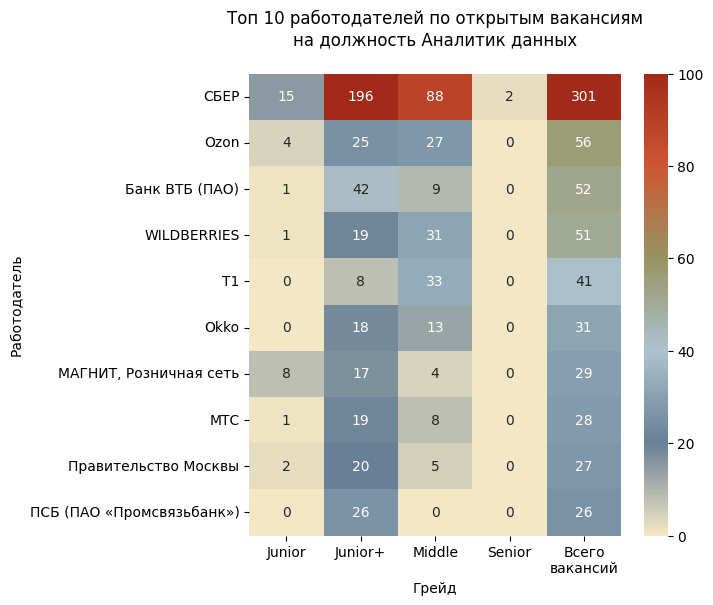

In [112]:
top_employers(df, 'Дата аналитик', 10)

- В топе присутствуют компании, относящиеся в основном к финансовому сектору, маркетплейсам, и ИТ компаниям.
- Среди первой десятки с огромным отрывом лидирует СБЕР, открывший в 10 раз больше вакансий чем остальные работодатели.
- Кроме СБЕРа никто из ТОПа не набирает специалистов уровня Senior.

##### Системные аналитики

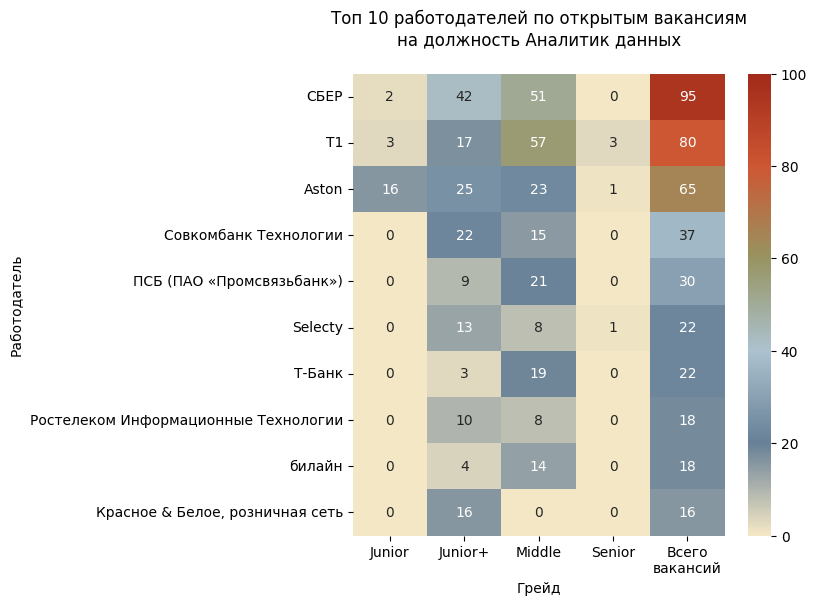

In [113]:
top_employers(df, 'Системный аналитик', 10)

- В топе преимущественно присутствуют работодатели из фин-сектора и ИТ-технологические компании.
- На первом месте, также как и с Аналитиками данных, находится СБЕР, но уже без кратного отрыва по количеству вакансий.

##### Промежуточный вывод
- На аналитиков обоих направлений имеется спрос в основном в:
    - Банки;
    - ИТ-технологии;
    - Операторы связи;
    - Продуктовые сети и маркетплейсы.
- Среди работодателей выделяется СБЕР, открывший наибольшее количество вакансий по всем направлениям;
- Сотрудников без опыта почти никто не набирает;
- Сотрудников уровня Senior тоже мало подбирают через сайт, вероятно используются иные каналы привлечения. 

#### Спрос по грейдам

Составим топ работодателей для каждого грейда в отдельности.

In [114]:
# Создадим функцию для составления топов
def get_top(df: pd.DataFrame, job: str, grade: str, n: int) -> pd.DataFrame:
    '''Функция определяет топ n работодателей по количеству открытых вакансий для переданных параметров.'''
    # Сформируем сводную
    result = (
        df[(df.job == job) & (df.grade == grade)]
        .employer
        .value_counts(ascending=False)
        .head(n)
    ).index.to_frame() 

    # Создадим иерархию в названии столбца
    result.columns = pd.MultiIndex.from_tuples([(job, grade)])

    # Вернем результат
    return result.reset_index(drop=True)


# Создадим пустой датафрейм для сбора результатов
top_by_job_grade = pd.DataFrame()

# Выполним цикл для определения топ-10 работодателей для каждого вида вакансии
for job in df.job.unique():
    for grade in df.grade.unique():
        top_by_job_grade = pd.concat([top_by_job_grade, get_top(df, job, grade, 10)], axis=1)

# Выведем результат
top_by_job_grade

Дата аналитик                                               \
                         Junior                    Junior+            Middle   
0                          СБЕР                       СБЕР              СБЕР   
1        МАГНИТ, Розничная сеть             Банк ВТБ (ПАО)                Т1   
2                DNS Технологии  ПСБ (ПАО «Промсвязьбанк»)       WILDBERRIES   
3           МПК (Призыванет.Ру)                       Ozon              Ozon   
4                          Ozon       Правительство Москвы             Aston   
5  Согласие, страховая компания                        МТС            Яндекс   
6                         ANCOR                WILDBERRIES              Okko   
7                         Полюс                       Okko            Контур   
8                         Aston                 Ростелеком           USETECH   
9            РЕСО-Гарантия, САО     МАГНИТ, Розничная сеть  Московская Биржа   

                                               Системный аналитик  \
                           Senior                          Junior   
0                    Леруа Мерлен                           Aston   
1            Онлайн-школа Тетрика  Компания Апогей (1С-франчайзи)   
2                            СБЕР       TWIGA Communication Group   
3                          Яндекс                          Дунайс   
4                Reinvent Baltics                        Ред Софт   
5                         НОВАТЭК                              Т1   
6       Мамаева Ирина Анатольевна     Центр финансовых технологий   
7                        CarMoney                          Спектр   
8  АО «ОТП Банк» (JSC «OTP Bank»)                             IBS   
9                      Медиапоинт                            СБЕР   

                                         \
                                Junior+   
0                                  СБЕР   
1                                 Aston   
2                 Совкомбанк Технологии   
3                                    Т1   
4       Красное & Белое, розничная сеть   
5                               Selecty   
6  Ростелеком Информационные Технологии   
7             ПСБ (ПАО «Промсвязьбанк»)   
8               Лига Цифровой Экономики   
9                                VILAVI   

                                          \
                                  Middle   
0                                     Т1   
1                                   СБЕР   
2                                  Aston   
3              ПСБ (ПАО «Промсвязьбанк»)   
4                                 Т-Банк   
5                  Прикладные технологии   
6                  Совкомбанк Технологии   
7                                 билайн   
8  Центральный банк Российской Федерации   
9                                    МТС   

                                                    
                                            Senior  
0                                               Т1  
1                                           Яндекс  
2                                       Mediascope  
3  БФТ-Холдинг (Бюджетные и Финансовые Технологии)  
4                                          ТестОпс  
5                                 ГРУППА МЕГАПОЛИС  
6                                  РНКБ Банк (ПАО)  
7                            Группа компаний Астра  
8                                          Эквирон  
9                                     Кловер Групп

##### Промежуточный вывод
Самые частые работодатели для Аналитика данных:
- Банки: СБЕР, ВТБ, ЦБ
- Маркетплейсы: WILDBERRIES, Ozon
- Телекоммуникционные компании: МТС, Ростелеком

Для системных аналитиков:
- Банки: СБЕР, Совкомбанк, Т-Банк
- ИТ-технологии: Т1, Aston, Ред Софт, 1С, Яндекс

#### Зарплатная вилка
Оценим распределение зарплатных предложений. Для начала посмотрим, сколько вакансий содержат записи с зарплатной вилкой.

##### Вакансии без данных

In [115]:
df.salary_bin.value_counts().reset_index()

,salary_bin,count
0,ЗП не указана,3963
1,От 100K до 200K,270
2,Меньше 100K,213
3,От 200K до 300K,149
4,Больше 300K,119


In [116]:
# Посчитаем долю вакансий без данных о зарплате
print(f"В {df[df.salary_bin == 'ЗП не указана'].shape[0] / df.shape[0]:.0%} вакансий зарплата не указана.")

В 84% вакансий зарплата не указана.


Посмотрим для каких грейдов чаще не указывают зарплату.

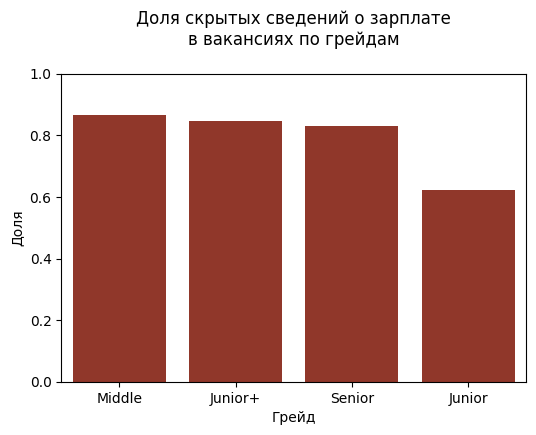

In [117]:
# Соберем таблицу, в одном столбце будет общее количество вакансий, во втором количество вакансий без данных о ЗП
no_salary = pd.concat([df.grade.value_counts(), df[df.salary_bin == 'ЗП не указана'].grade.value_counts()], axis=1)

# Переименуем столбцы
no_salary.columns = ['total', 'no_data']

# Посчитаем доли
no_salary['share'] = no_salary.no_data / no_salary.total

# Настроим диаграмму
plt.figure(figsize=(6, 4))
sns.barplot(data=no_salary.reset_index().sort_values(by='share', ascending=False), x='grade', y='share', color=cmap.colors[-1])
plt.ylim(0, 1)
plt.ylabel('Доля')
plt.xlabel('Грейд')
plt.title('Доля скрытых сведений о зарплате\nв вакансиях по грейдам\n')

# Выведем на экран
plt.show()

Чаще всего зарплату не указывают для грейда Middle, а у Junior (без опыта) наибольшее количество открытых данных.

##### Зарплаты по грейдам

In [118]:
# Создадим функцию
def salary_share_heatmap(df: pd.DataFrame, job: str) -> None:
    '''Построение хитмепа с долями вакансий по зарплатным предложениям и грейдам.'''
    index_order = [
        'Меньше 100K', 
        'От 100K до 200K', 
        'От 200K до 300K', 
        'Больше 300K']

    # Отфильтруем данные и сделаем сводную таблицу
    salary_pivoted = (
        df[(df.salary_bin != 'ЗП не указана') & (df.job == job)]
        .pivot_table(
            index='salary_bin', 
            columns='grade', 
            values='id', 
            aggfunc='count', 
            fill_value=0
            )
        .reindex(index_order)
    )

    # Добавим столбец, в котором посчитаем долю вакансий в рамках грейда
    salary_share = salary_pivoted.div(salary_pivoted.sum(axis=0), axis=1)

    # Построим и настроим хитмап
    plt.figure(figsize=(6, 5))
    sns.heatmap(data=salary_share, cmap=cmap, fmt='.0%', annot=True)
    plt.ylabel('Зарплата')
    plt.xlabel('Грейд')
    plt.title(f'Распределение зарплатных предложений в долях по грейдам\nдля вакансий {job}\n')

    # Отобразим диаграмму
    plt.show()

##### Дата аналитики

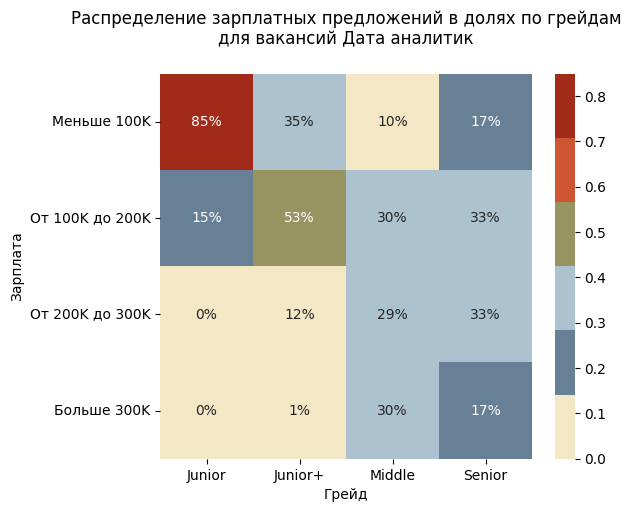

In [119]:
salary_share_heatmap(df, 'Дата аналитик')

- В вакансиях дата аналитиков распределение зарплат на высоких грейдах очень разнобразное.
- Специалисты Junior и Junior+ чаще оцениваются до 200к;
- Начиная с Middle уровня можно претендовать на больший спектр зарплат, в зависимости от специализации.

##### Системные аналитики

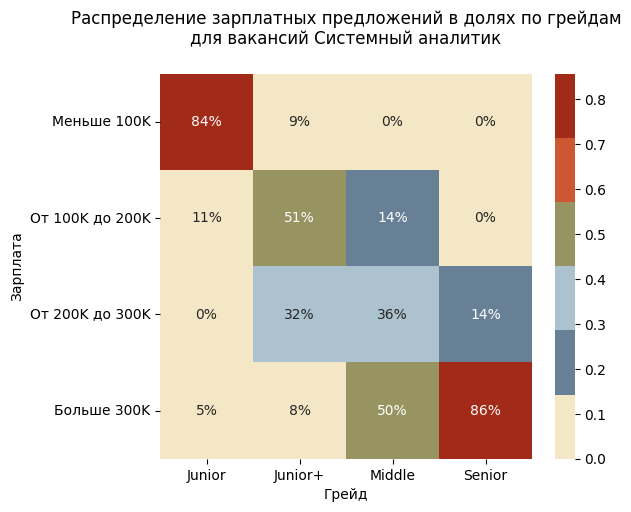

In [120]:
salary_share_heatmap(df, 'Системный аналитик')

- На диаграмме заметна выраженная корреляция зарплатных предложений и грейда кандидата;
- Системным аналитикам уровня Junior+ чаще предлагают от 100 до 300к, но уже на Middle уровне половина предложений составляет 300+;
- Есть выбросы в виде предложений от 300к в категории уровня Junior.

Посмотрим на выбросы

In [121]:
pd.set_option('display.max_colwidth', 350)

outliers = df.query("job == 'Системный аналитик' and grade == 'Junior' and salary_bin == 'Больше 300K'")[['employer', 'description', 'key_skills']]
display(outliers)

pd.set_option('display.max_colwidth', 50)

,employer,description,key_skills
3475,Offer Now,"обязанности: написание технического задание на разработку выявление потребности бизнеса описание функциональный и не функциональных требований проектирование баз данных поддержание актуальности документации требования: умение писать понятную документацию наличие высшего it образования знание sql опыт проектирования интеграций, как синхронны...",['Документация']
4158,Консалт Плюс,"компания отвечает за создание и развитие высоконагруженной корпоративной системы. мы гордимся тем, что нашими заказчиками являются ведущие холдинги и госкорпорации, предприятия промышленности, топливо-энергетические и финансовые организации. главная ценность нашей компании — это люди, которые в ней работают. в нашей команде собраны специалисты ...","['REST', 'SQL', 'Atlassian Jira', 'Документация', 'Agile', 'UML', 'confluence', 'BPMN', 'Коммуникация', 'OpenAPI', 'Системный анализ', 'Atlassian Confluence']"


Судя по описанию и требуемым навыкам налицо ошибка в категоризации.

##### Промежуточный вывод

Очень часто в вакансиях отсутствуют данные о зарплатных предложениях. В исследуемом сете только 18% записей заполнены. Больше всего информации по вакансиям уровня Junior.
Аналитики данных:
- В вакансиях дата аналитиков распределение зарплат на высоких грейдах очень разнобразное.
- Специалисты Junior и Junior+ чаще оцениваются до 200к;
- Начиная с Middle уровня можно претендовать на больший спектр зарплат, в зависимости от специализации.

Системные аналитики:
- На диаграмме заметна выраженная корреляция зарплатных предложений и грейда кандидата;
- Системным аналитикам уровня Junior+ чаще предлагают от 100 до 300к, но уже на Middle уровне половина предложений составляет 300+;
- Есть выбросы в виде предложений от 300к в категории уровня Junior.


#### Тип занятости


In [122]:
# Создадим функцию 
def employment_type(df: pd.DataFrame, job: str) -> pd.DataFrame:
    '''Функция формирует сводную и добавляет форматирование'''
    result = (
        df[df.job == job]
        .pivot_table(
            index='employment', 
            columns='grade', 
            values='id', 
            aggfunc='count', 
            fill_value=0
        ).sort_values(by='Junior', ascending=False)
        .style
        .format("{:.0f}")
        .background_gradient(cmap=cmap_cont)
    )
    
    return result


# Выведем таблицы на экран
display('Системный аналитик')
display(employment_type(df, 'Системный аналитик'))
display('Дата аналитик')
display(employment_type(df, 'Дата аналитик'))

'Системный аналитик'

grade,Junior,Junior+,Middle,Senior
employment,,,,
Полная занятость,56,851,926,44
Стажировка,29,0,0,0
Частичная занятость,1,0,5,0
Проектная работа,0,1,2,0


'Дата аналитик'

grade,Junior,Junior+,Middle,Senior
employment,,,,
Полная занятость,173,1646,880,33
Стажировка,29,4,0,0
Частичная занятость,5,13,9,0
Проектная работа,2,4,1,0


##### Промежуточный вывод
- Преимущественно набор ведется на полную занятость; 
- Стажировку предлагают только кандидатам Junior;
- Частичная занятость встречается чаще среди вакансий дата аналитиков.

#### График работы

Посмотрим в каком графике работают специалисты разных грейдов

In [123]:
# Создадим функцию 
def schedule_type(df: pd.DataFrame, job: str) -> pd.DataFrame:
    '''Функция формирует сводную и добавляет форматирование'''
    result = (
        df[df.job == job]
        .pivot_table(
            index='schedule', 
            columns='grade', 
            values='id', 
            aggfunc='count', 
            fill_value=0
        ).sort_values(by='Middle', ascending=False)
        .style
        .format("{:.0f}")
        .background_gradient(cmap=cmap_cont)
    )
    
    return result


# Выведем таблицы на экран
display('Системный аналитик')
display(schedule_type(df, 'Системный аналитик'))
display('Дата аналитик')
display(schedule_type(df, 'Дата аналитик'))

'Системный аналитик'

grade,Junior,Junior+,Middle,Senior
schedule,,,,
Полный день,51,553,574,25
Удаленная работа,29,263,341,17
Гибкий график,6,36,17,2
Сменный график,0,0,1,0


'Дата аналитик'

grade,Junior,Junior+,Middle,Senior
schedule,,,,
Полный день,175,1379,642,23
Удаленная работа,24,235,226,9
Гибкий график,6,37,22,1
Сменный график,4,16,0,0


##### Промежуточный вывод
- Чаще всего работа предполагает присутствие в офисе на полный рабочий день;
- Удаленная работа для Junior предлагается крайне редко;
- Гибкий и сменный график встречается редко.

### Виды навыков 

Рассмотрим навыки кандидатов, разделим их на soft и hard, определим, какие встречаются чаще.

In [124]:
print(df.key_skills[0])

type(df.key_skills[0])

['Power BI', 'СУБД', 'Python', 'SQL']


str

Данные хранятся в виде строки в форме списка list(). Очистим строку от символов скобок и кавычек, после чего сформируем корректный список.

In [125]:
(df.key_skills
    .apply(lambda x: x.strip('[]') # уберем квадратные скобки
    .replace("'", '')              # уберем лишние кавычки
    .lower()                       # приведем текст к нижнему регистру
    .split(', '))                  # превратим в список
    .explode()                     # вытянем значения списков в ячейках в общий вертикальный список
    .value_counts()                # посчитаем частоту появления требований
).reset_index().head(10)

,key_skills,count
0,sql,1812
1,документация,1571
2,,946
3,python,923
4,аналитическое мышление,741
5,confluence,701
6,bpmn,664
7,анализ данных,604
8,системный анализ,597
9,uml,579


Из получившейся таблицы видно, что среди всех вакансий самыми распространенными требованиями являются Документация и SQL. Но в получившемся списке нет деления на soft и hard. С помощью нейросети выделим из данных только soft скиллы.

In [126]:
soft_skills = [
    'аналитическое мышление',
    'коммуникация',
    'работа с большим объемом информации',
    'проактивность',
    'переговоры',
    'работа в команде',
    'деловая коммуникация',
    'аналитический склад ума',
    'системное мышление',
    'подготовка презентаций',
    'аналитические способности',
    'креативность',
    'системный подход',
    'организаторские навыки',
    'обучение и развитие',
    'ответственность',
    'грамотная речь',
    'деловая переписка',
    'навыки презентации',
    'управление командой',
    'критическое мышление',
    'точность и внимательность к деталям',
    'умение принимать решения',
    'удаленная работа',
    'наставничество',
    'проведение презентаций',
    'навыки переговоров',
    'коммуникабельность',
    'планирование',
    'аналитические навыки',
    'менеджмент',
    'умение работать в коллективе',
    'ориентация на результат',
    'доброжелательность',
    'деловое общение',
    'способность к саморазвитию',
    'адаптивность',
    'решение проблем',
    'инициативность и лидерство',
    'коммуникативная гибкость',
    'системность мышления',
    'ведение отчетности',
    'принятие решений',
    'грамотность',
    'оценка рисков',
    'тайм-менеджмент',
    'амбициозность',
    'стрессоустойчивость',
    'внимание к деталям',
    'стратегическое мышление',
    'грамотная речь и письмо',
    'умение работать в команде',
    'логическое мышление',
    'руководство коллективом',
    'презентация результатов',
    'клиентоориентированность',
    'ведение переписки',
    'поиск информации в интернет',
    'умение работать в команде',
    'критическое мышление',
    'планирование',
    'доброжелательность',
    "Проведение телефонных интервью",
    "Деловая коммуникация",
    "Общение с клиентами",
    "Работа в условиях многозадачности",
    "Скрупулезность",
    "Инициативность в решении задач",
    "Желание постоянно развиваться",
    "Внимательность",
    "Ответственный подход к работе",
    "Дружелюбие",
    "Обучаемость",
    "Готовность обучаться",
    "Гибкость мышления",
    "Желание развиваться",
    "Умение анализировать",
    "Добросовестность",
    "Мотивированность",
    "Эмпатия",
    "Навыки межличностного общения",
    "Деловая коммуникация",
    "Навыки продаж",
    "Организация совещаний",
    "Организация мероприятий",
    "Инициативность",
    "Выстраивание метрик",
    "Руководство командой",
    "Управление временем",
    "Управление ожиданиями",
    "Способность к систематизации",
    "Умение легко находить контакт с людьми",
    "Способность эффективно решать проблемы",
    "Внимательность к деталям",
    "Желание зарабатывать",
    "Коммуникативные навыки",
    "Лидерство",
    "Усидчивость",
    "Умение анализировать информацию",
    "Планирование и организация",
    "Умение работать в условиях многозадачности",
    "Системное мышление",
    "Активная позиция",
    "Интерес и широкий кругозор",
    "Желание работать и развиваться",
    "Письменная коммуникация",
    "Ориентация на клиента",
    "Организационные навыки",
    "Целеустремленность",
    "Ведение переговоров",
    "Управление персоналом",
    "Рекрутмент",
    "Управление продажами",
    "Прогнозирование продаж"
]


Так как в данных навыки представлены в одном поле, сформируем таблицу, где вид вакансии и грейд выделим в индекс, а колонку с навыками расширим.

In [127]:
# Отфильтруем необходимые поля
df_skills = df[['job', 'grade', 'key_skills']].dropna()

# Обработаем поле с навыками как в примере выше
df_skills.key_skills = df_skills.key_skills.apply(
    lambda x: (x.strip('[]')
                .replace("'", '')
                .lower()
                .split(', '))
)

df_skills.head()

,job,grade,key_skills
0,Дата аналитик,Junior,"[power bi, субд, python, sql]"
1,Дата аналитик,Junior,"[ms sql, работа с базами данных, ms excel]"
2,Дата аналитик,Junior+,"[sql, power bi, субд, python, clickhouse, bpmn]"
3,Дата аналитик,Junior+,"[анализ данных, коммуникация, sql, ms office, ..."
4,Дата аналитик,Middle,[документация]


Раскроем список вниз, повторяя ключи (вакансию и грейды).

In [128]:
df_skills = df_skills.set_index(['job', 'grade']).explode('key_skills').dropna()

df_skills.head()

key_skills
job           grade            
Дата аналитик Junior   power bi
              Junior       субд
              Junior     python
              Junior        sql
              Junior     ms sql

Теперь добавим столбец с категорией навыка, проверив каждый на соответствие со списком soft скиллов.

In [129]:
# Сформируем столбец с категорией
df_skills['skill_type'] = df_skills.key_skills.apply(lambda x: 'soft' if x in soft_skills else 'hard')

# Отфильтруем пустые строки
df_skills = df_skills[df_skills.key_skills != '']

df_skills.head()

key_skills skill_type
job           grade                       
Дата аналитик Junior   power bi       hard
              Junior       субд       hard
              Junior     python       hard
              Junior        sql       hard
              Junior     ms sql       hard

In [130]:
# Сделаем сводную, посчитав частоту появления навыков разных видов в вакансиях по грейдам
df_skills_pivot = (df_skills
    .reset_index()
    .pivot_table(
        index=['job', 'grade'], 
        columns='skill_type', 
        aggfunc='count', 
        fill_value=0)
)


# Добавим столбец с долей софт скиллов
soft_count = df_skills_pivot[('key_skills', 'soft')]
total_count = (
    df_skills_pivot[('key_skills', 'soft')] 
    + df_skills_pivot[('key_skills', 'hard')]
)

df_skills_pivot['soft_share'] = soft_count / total_count

# Отформатируем итоговую таблицу
df_skills_pivot = (
    df_skills_pivot
    .reset_index()
    .style.format(
        "{:.2%}", 
        subset='soft_share'
    ).bar(
        subset=['soft_share'], 
        vmax=1, 
        color=cmap.colors[2]))

df_skills_pivot

##### Промежуточные выводы
- soft скиллы в требованиях составляют не больше пятой части от всех скиллов;
- Больше всего разнообразных навыков в вакансиях дата аналитиков указывают для уровня Junior+;
- У системных аналитиков уровня Junior+ и Middle представлено максимальное разнообразие навыков;
- Доля soft скиллов среди требуемых навыков ко всем аналитикам выше для Junior. Доля падает с ростом грейда.
 

### Требования к кандидатам
Определим самый распространенный набор компетенций для сотрудников по грейдам.


Определим самые распространенные навыки для разных вакансий.

In [131]:
# Созданим функцию
def get_skills(data: pd.DataFrame, job: str, skill_type: str, n: int) -> pd.DataFrame:
    '''Получаем список ключевых навыков по заданной вакансии и типу навыка. 
    Итоговая таблица содержит столбцы для каждого грейда специалиста.'''
    # Пустой словарь для сбора результата
    skill_dict = dict()
    
    # В цикле пройдемся по всем грейдам и сформируем топ навыков
    for grade in data.reset_index().grade.unique():
        skills_list = (
            data.reset_index()
            .query(f"job == '{job}' and grade == '{grade}' and skill_type == '{skill_type}'")
            .key_skills
            .value_counts()
            .head(n)
            .index.tolist()
        )

        # Увеличим список пустыми строками до необходимой длины
        if len(skills_list) < n:
            skills_list += ['' for _ in range(n - len(skills_list))]

        # Добавим список в словарь с результатами
        skill_dict.setdefault(grade, skills_list)

    # Преобразуем словарь в датафрейм
    skills_df = pd.DataFrame(skill_dict)

    return skills_df

Посмотрим как меняется набор топ 10 навыков в зависимости от грейда вакансии дата аналитиков.

##### hard skills

In [132]:
get_skills(df_skills, 'Дата аналитик', 'hard', 5)

,Junior,Junior+,Middle,Senior
0,sql,sql,sql,sql
1,анализ данных,python,python,python
2,python,анализ данных,анализ данных,power bi
3,ms excel,ms excel,pandas,pandas
4,pandas,power bi,power bi,confluence


От дата аналитика требуются следующие hard skills:
- SQL прочно занимает первое место;
- Знания python и pandas ценятся всегда;
- Excel встречается в топе требований к Junior и Junior+, но выше уже не нужен;
- Визуализация с использованием Power BI встречается чаще с ростом грейда.

In [133]:
get_skills(df_skills, 'Системный аналитик', 'hard', 5)

,Junior,Junior+,Middle,Senior
0,документация,документация,документация,документация
1,sql,bpmn,sql,sql
2,системный анализ,sql,bpmn,uml
3,бизнес-анализ,confluence,confluence,bpmn
4,bpmn,uml,системный анализ,системный анализ


У системных аналитиков совершенно другой набор навыков:
- На первом месте написание документации, у всех грейдов;
- Не менее важным будет умение писать код SQL;
- Обязательно знание BPMN, UML.

##### soft skills

In [134]:
get_skills(df_skills, 'Дата аналитик', 'soft', 5)

,Junior,Junior+,Middle,Senior
0,аналитическое мышление,аналитическое мышление,аналитическое мышление,проактивность
1,работа с большим объемом информации,работа с большим объемом информации,работа с большим объемом информации,презентация результатов
2,коммуникация,коммуникация,коммуникация,коммуникация
3,работа в команде,аналитический склад ума,проактивность,аналитическое мышление
4,проактивность,проактивность,подготовка презентаций,внимание к деталям


Для аналитика данных всегда требуется:
- Аналитический склад ума;
- Работа с большим объемом информации;
- Навыки коммуникации;
- Проактивность и внимательность будут большим плюсом.

In [135]:
get_skills(df_skills, 'Системный аналитик', 'soft', 5)

,Junior,Junior+,Middle,Senior
0,аналитическое мышление,аналитическое мышление,коммуникация,коммуникация
1,аналитический склад ума,коммуникация,аналитическое мышление,переговоры
2,обучение и развитие,проактивность,проактивность,креативность
3,коммуникация,работа с большим объемом информации,переговоры,аналитическое мышление
4,ответственность,системное мышление,работа с большим объемом информации,логическое мышление


В требованиях к системным аналитикам реже встречается работа с большим объемом информации, но коммуникация выходит на передний план.

## Итоговый вывод

#### Портреты типичных условий труда

**Аналитики данных:**
1. **ТОП-10 работодателей:** В основном финансовый сектор (СБЕР, ВТБ), маркетплейсы (WILDBERRIES, Ozon) и ИТ-компании (T1, Яндекс).
2. **Зарплатная вилка:**
   - Junior и Junior+: до 200K.
   - Middle и Senior: разнообразные предложения, в зависимости от специализации.
3. **Тип занятости:** Преимущественно полная занятость, стажировка предлагается только Junior.
4. **График работы:** В основном полный рабочий день, удаленная работа для Junior предлагается редко.

**Системные аналитики:**
1. **ТОП-10 работодателей:** Финансовый сектор (СБЕР, Совкомбанк, Т-Банк) и ИТ-технологические компании (T1, Aston, Яндекс).
2. **Зарплатная вилка:**
   - Junior+: от 100K до 300K.
   - Middle: половина предложений составляет 300K+.
3. **Тип занятости:** Преимущественно полная занятость.
4. **График работы:** В основном полный рабочий день, удаленная работа для Junior предлагается редко.

#### Портреты ожидаемого работника

**Аналитики данных:**
1. **Junior:**
   - Hard skills: SQL, Python, Excel.
   - Soft skills: Аналитическое мышление, работа с большим объемом информации, коммуникация, работа в команде, проактивность.
2. **Junior+:**
   - Hard skills: SQL, Python, Excel, Power BI.
   - Soft skills: Аналитическое мышление, работа с большим объемом информации, коммуникация, аналитический склад ума, проактивность.
3. **Middle:**
   - Hard skills: SQL, Python, Pandas, Power BI.
   - Soft skills: Аналитическое мышление, работа с большим объемом информации, коммуникация, проактивность, подготовка презентаций.
4. **Senior:**
   - Hard skills: SQL, Python, Pandas, Confluence.
   - Soft skills: Проактивность, презентация результатов, коммуникация, аналитическое мышление, внимание к деталям.

**Системные аналитики:**
1. **Junior:**
   - Hard skills: Документация, SQL, системный анализ, BPMN.
   - Soft skills: Аналитическое мышление, аналитический склад ума, обучение и развитие, коммуникация, ответственность.
2. **Junior+:**
   - Hard skills: Документация, BPMN, SQL, Confluence, UML.
   - Soft skills: Аналитическое мышление, коммуникация, проактивность, работа с большим объемом информации, системное мышление.
3. **Middle:**
   - Hard skills: Документация, SQL, BPMN, Confluence, системный анализ.
   - Soft skills: Коммуникация, аналитическое мышление, проактивность, переговоры, работа с большим объемом информации.
4. **Senior:**
   - Hard skills: Документация, SQL, UML, BPMN, системный анализ.
   - Soft skills: Коммуникация, переговоры, креативность, аналитическое мышление, логическое мышление.

### Заключение

На рынке труда для аналитиков данных и системных аналитиков существуют различия в типичных условиях труда и требованиях к кандидатам. Аналитики данных чаще востребованы в финансовом секторе и маркетплейсах, тогда как системные аналитики — в финансовом секторе и ИТ-технологических компаниях. Зарплатные предложения и требования к навыкам также различаются в зависимости от грейда и типа аналитика.